**Leaf** **Disease** **Prediction** **using** **Deeplearning**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import Dependencies


In [17]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
import matplotlib.pyplot as plt
import os
import numpy as np
import json
from PIL import Image
from tensorflow.keras.applications.resnet50 import ResNet50
import glob

In [5]:
 %cd "/content/drive/MyDrive/Project"

/content/drive/MyDrive/Project


In [6]:
# path of the data
data_dir= "/content/drive/MyDrive/Project"

In [7]:
#Set all the Constants
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=20

In [8]:
#Import data into tensorflow dataset object

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 13615 files belonging to 12 classes.


In [9]:
# class names
class_names=dataset.class_names
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

Visualize some of the images from the dataset

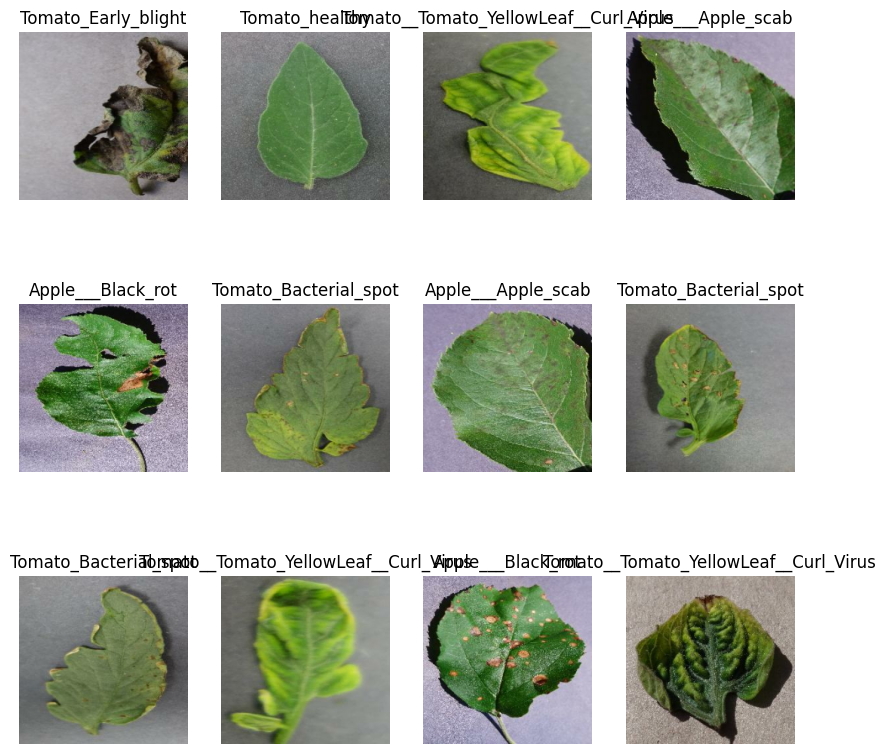

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [10]:
# Image Data Generators
data_generator=ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [11]:
# Train Generator
training_set = data_generator.flow_from_directory(
    data_dir,
    target_size=(IMAGE_SIZE , IMAGE_SIZE ),
    batch_size=BATCH_SIZE,
    subset='training',
    class_mode='categorical'
)

Found 10895 images belonging to 12 classes.


In [ ]:
# Validation Generator
validation_set = data_generator.flow_from_directory(
    data_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode='categorical'
)


Found 2720 images belonging to 12 classes.


In [ ]:
# Building Model using

input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)
resNet152V2 = ResNet152V2(input_shape=input_shape, weights='imagenet', include_top=False)

234545216/234545216 [==============================] - 6s 0us/step


In [ ]:
# Freeze the weights of the pre-trained layers
for layer in resNet152V2.layers:
    layer.trainable = False

In [ ]:
num_classes = len(training_set.class_indices)  # Get the number of classes from the training set
num_classes

12

In [ ]:
# Flatten the output of ResNet152V2
x = Flatten()(resNet152V2.output)

In [ ]:
 #Add a dense layer with softmax activation for classification
prediction = Dense(num_classes, activation='softmax')(x)

# create a model object
model = Model(inputs=resNet152V2.input, outputs=prediction)

In [ ]:
# Compile the model with an appropriate optimizer, loss function, and evaluation metrics
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Display model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                            

In [ ]:
# Training the Model
history = model.fit(
    training_set,
    steps_per_epoch=training_set.samples //BATCH_SIZE,  # Number of steps per epoch
    epochs=20,  # Number of epochs
    validation_data=validation_set,
    validation_steps=validation_set.samples // BATCH_SIZE  # Validation steps
)

Epoch 1/20
340/340 [==============================] - 5522s 16s/step - loss: 1.8033 - accuracy: 0.8869 - val_loss: 1.0059 - val_accuracy: 0.9401
Epoch 2/20
340/340 [==============================] - 94s 277ms/step - loss: 0.3801 - accuracy: 0.9741 - val_loss: 0.6228 - val_accuracy: 0.9665
Epoch 3/20
340/340 [==============================] - 96s 283ms/step - loss: 0.2186 - accuracy: 0.9839 - val_loss: 0.8879 - val_accuracy: 0.9592
Epoch 4/20
340/340 [==============================] - 96s 283ms/step - loss: 0.2059 - accuracy: 0.9861 - val_loss: 0.9184 - val_accuracy: 0.9647
Epoch 5/20
340/340 [==============================] - 96s 283ms/step - loss: 0.1999 - accuracy: 0.9889 - val_loss: 0.8663 - val_accuracy: 0.9684
Epoch 6/20
340/340 [==============================] - 96s 283ms/step - loss: 0.2400 - accuracy: 0.9867 - val_loss: 1.2033 - val_accuracy: 0.9566
Epoch 7/20
340/340 [==============================] - 96s 283ms/step - loss: 0.1421 - accuracy: 0.9922 - val_loss: 0.5604 - val_ac

In [ ]:
model.save('trained_plant_disease_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model Evaluation

In [ ]:
#Training set Accuracy
train_loss, train_accuracy = model.evaluate(training_set)
print(f"Training accuracy: {train_accuracy * 100:.2f}%")

# Validation set accuaracy

val_loss,val_accuracy=model.evaluate(validation_set)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

341/341 [==============================] - 78s 228ms/step - loss: 0.0881 - accuracy: 0.9972
Training accuracy: 99.72%
85/85 [==============================] - 19s 226ms/step - loss: 2.1904 - accuracy: 0.9691
Validation Accuracy: 96.91%


**Model Evaluation**

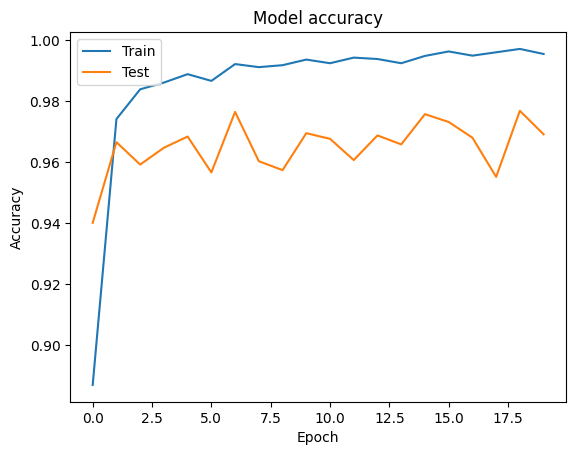

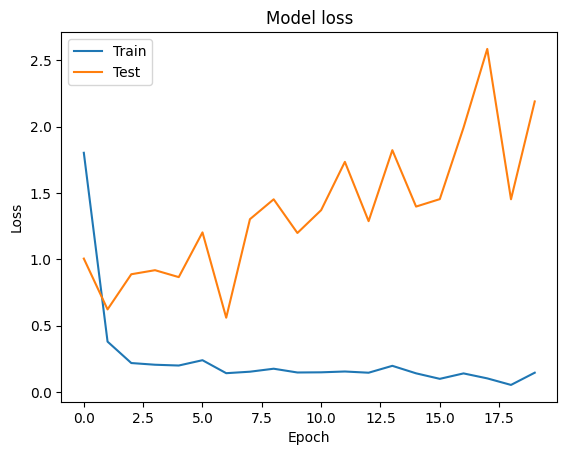

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



In [12]:
model = tf.keras.models.load_model('trained_plant_disease_model.h5')

In [13]:
# Buiding a predictive system

# Function to Load and Preprocess the Image using Pillow
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    # Load the image
    img = Image.open(image_path)
    # Resize the image
    img = img.resize(target_size)
    # Convert the image to a numpy array
    img_array = np.array(img)
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    # Scale the image values to [0, 1]
    img_array = img_array.astype('float32') / 255.
    return img_array

# Function to Predict the Class of an Image
def predict_image_class(model, image_path, class_indices):
    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_indices[predicted_class_index]
    return predicted_class_name


In [14]:
# Create a mapping from class indices to class names
class_indices = {v: k for k, v in training_set.class_indices.items()}
class_indices

{0: 'Apple___Apple_scab',
 1: 'Apple___Black_rot',
 2: 'Apple___Cedar_apple_rust',
 3: 'Apple___healthy',
 4: 'Potato___Early_blight',
 5: 'Potato___Late_blight',
 6: 'Potato___healthy',
 7: 'Tomato_Bacterial_spot',
 8: 'Tomato_Early_blight',
 9: 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 10: 'Tomato__Tomato_mosaic_virus',
 11: 'Tomato_healthy'}

In [15]:
# saving the class names as json file
json.dump(class_indices, open('class_indices.json', 'w'))

Prediction on a single image


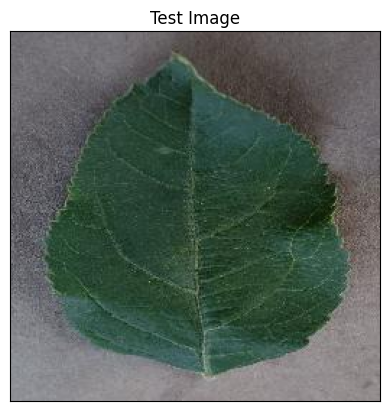

In [20]:
#Test Image Visualization
import cv2
image_path = '/content/drive/MyDrive/Test_images/Apple _healthy.JPG'
# Reading an image in default mode
img = cv2.imread(image_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB) #Converting BGR to RGB
# Displaying the image
plt.imshow(img)
plt.title('Test Image')
plt.xticks([])
plt.yticks([])
plt.show()

In [19]:

predicted_class_name = predict_image_class(model, image_path, class_indices)
# Output the result
print("Predicted Class Name:", predicted_class_name)


1/1 [==============================] - 0s 32ms/step
Predicted Class Name: Apple___healthy
